In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy.stats as stats
from sklearn import preprocessing
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from matplotlib.cm import register_cmap
from scipy import stats
from sklearn.decomposition import PCA as sklearnPCA

In [2]:
# S&P 500 companies' fundamental data.
df = pd.read_csv('fundamentals.csv')
df.dtypes

Unnamed: 0                                               int64
Ticker Symbol                                           object
Period Ending                                           object
Accounts Payable                                       float64
Accounts Receivable                                    float64
Add'l income/expense items                             float64
After Tax ROE                                          float64
Capital Expenditures                                   float64
Capital Surplus                                        float64
Cash Ratio                                             float64
Cash and Cash Equivalents                              float64
Changes in Inventories                                 float64
Common Stocks                                          float64
Cost of Revenue                                        float64
Current Ratio                                          float64
Deferred Asset Charges                                 

In [3]:
# Convert Period Ending column to date format and create year column.
df['Period Ending'] = pd.to_datetime(df['Period Ending'])
df['year'] = df['Period Ending'].dt.year

# Show number of stocks by year.
df.groupby('year').count()['Ticker Symbol']

year
2003      1
2004      1
2006      1
2007      1
2012    236
2013    439
2014    436
2015    445
2016    220
2017      1
Name: Ticker Symbol, dtype: int64

In [4]:
# Create a subset.
df_sub = df.loc[(df['year']==2015)|(df['year']==2014), ['Ticker Symbol', 'Capital Expenditures', 'Earnings Before Interest and Tax', 'Gross Profit', 'Profit Margin', 'Total Assets', 'Total Liabilities', 'year']]
df_sub.head()

,Ticker Symbol,Capital Expenditures,Earnings Before Interest and Tax,Gross Profit,Profit Margin,Total Assets,Total Liabilities,year
2,AAL,-5.311000e+09,4.099000e+09,2.703000e+10,7.0,4.322500e+10,4.120400e+10,2014
3,AAL,-6.151000e+09,5.496000e+09,2.989400e+10,19.0,4.841500e+10,4.278000e+10,2015
6,AAP,-2.284460e+08,8.548020e+08,4.453613e+09,5.0,7.962358e+09,5.959446e+09,2015
9,AAPL,-9.571000e+09,5.348300e+10,7.053700e+10,22.0,2.318390e+11,1.202920e+11,2014
10,AAPL,-1.124700e+10,7.251500e+10,9.362600e+10,23.0,2.903450e+11,1.709900e+11,2015


C:\Users\James\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
C:\Users\James\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


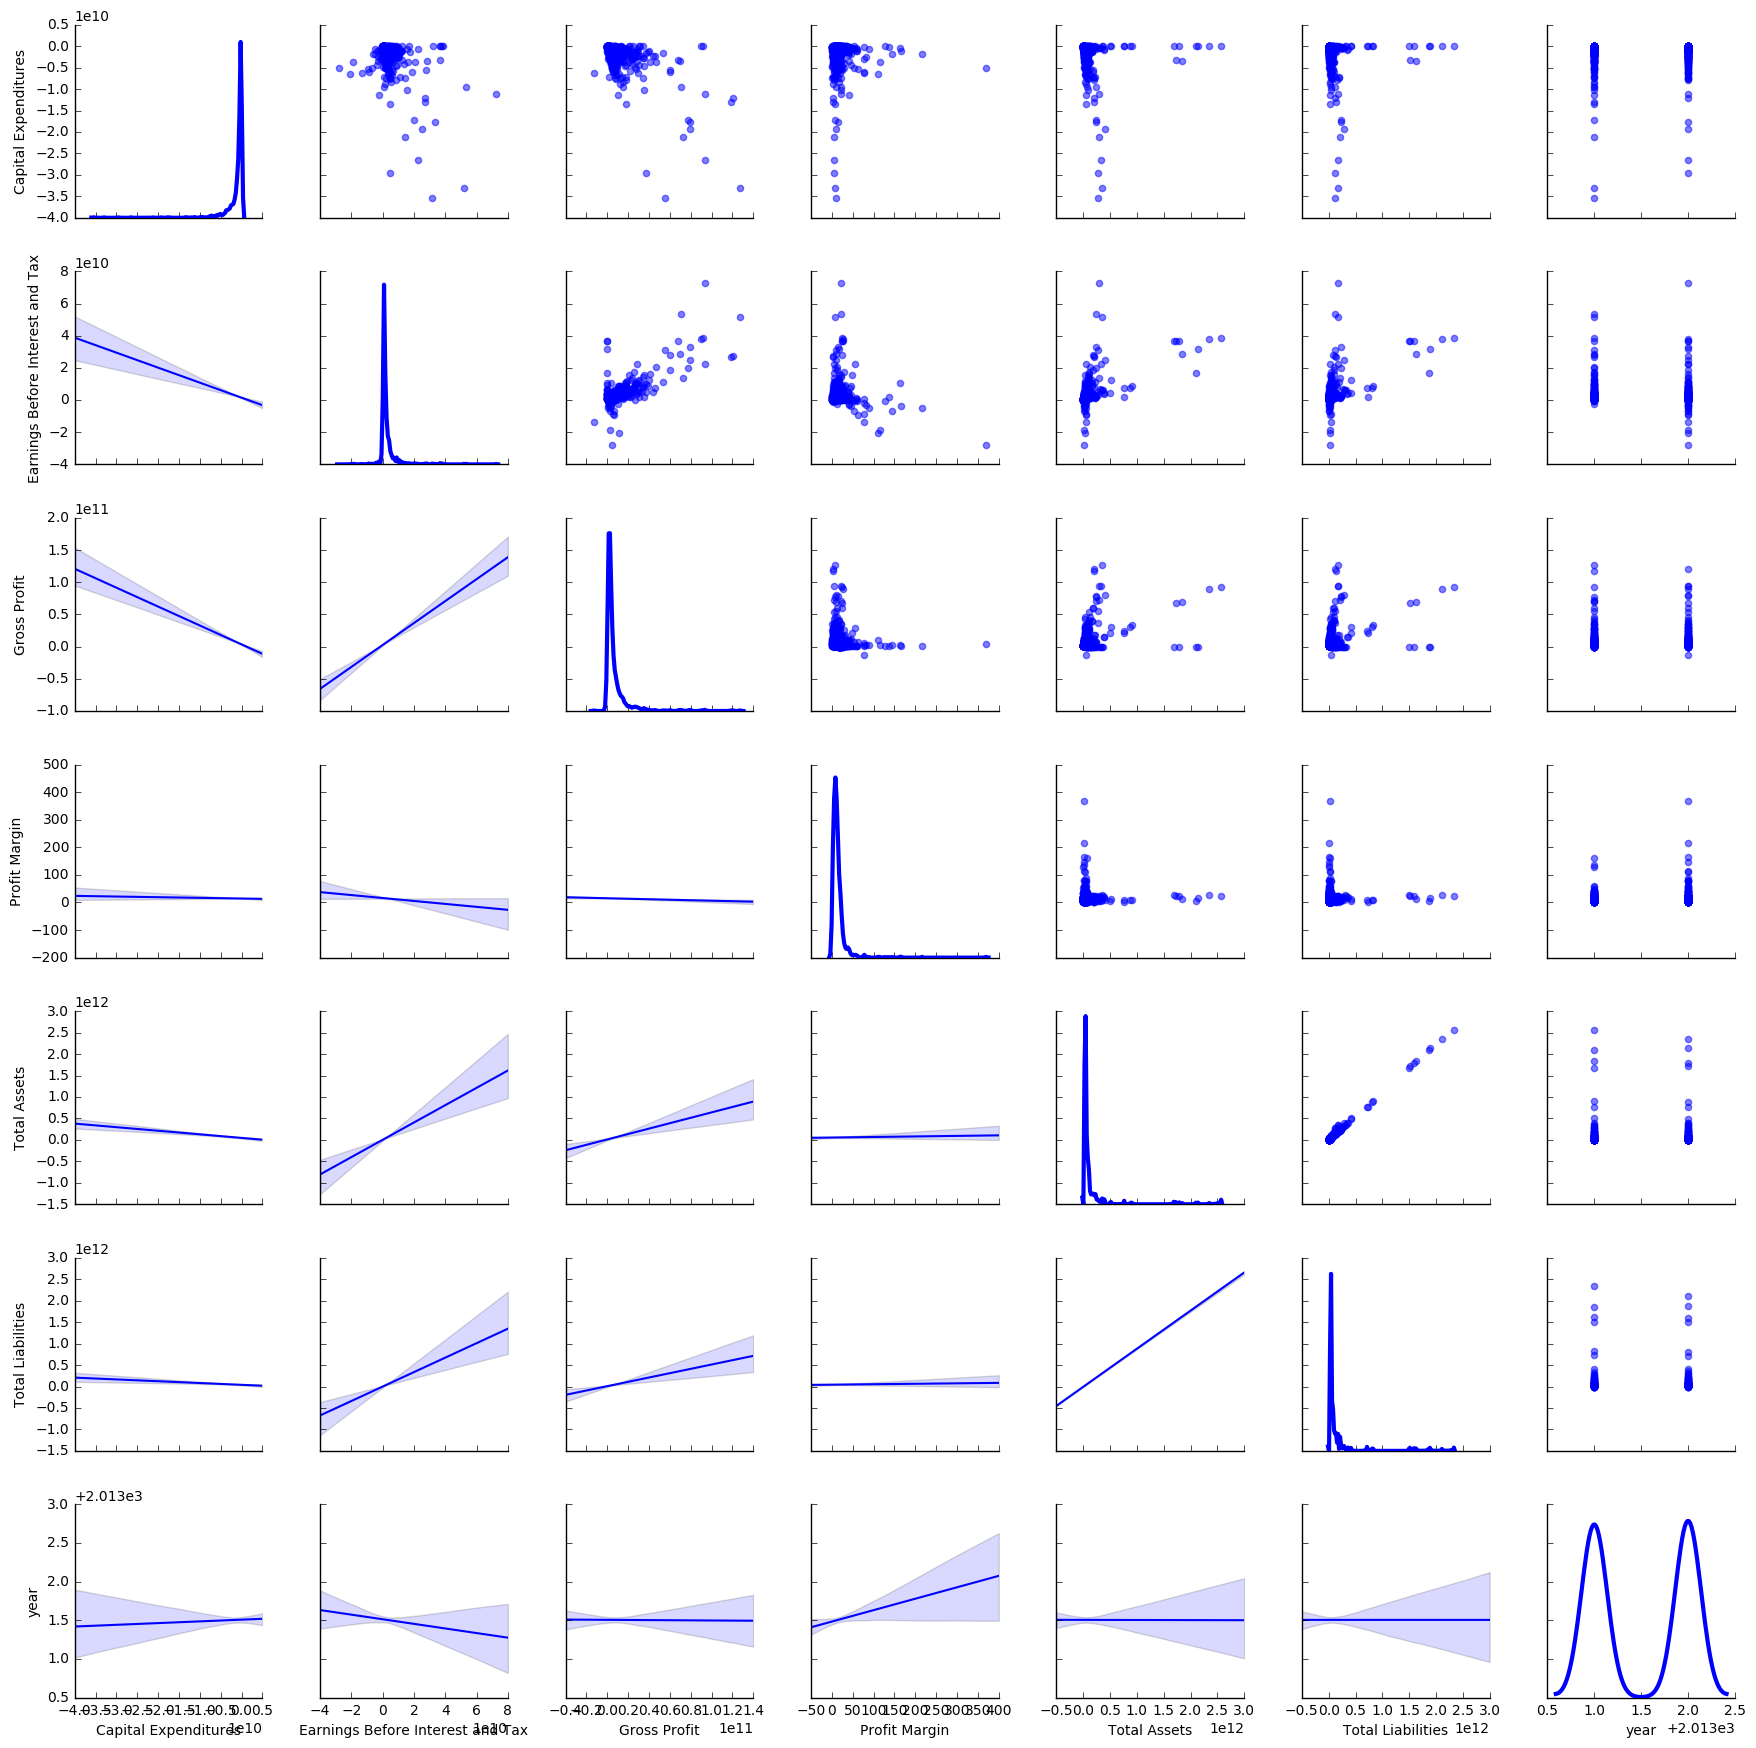

In [5]:
# Show univariate distributions of the variables.
g = sns.PairGrid(df_sub.dropna(), diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot, lw=3)
plt.show()

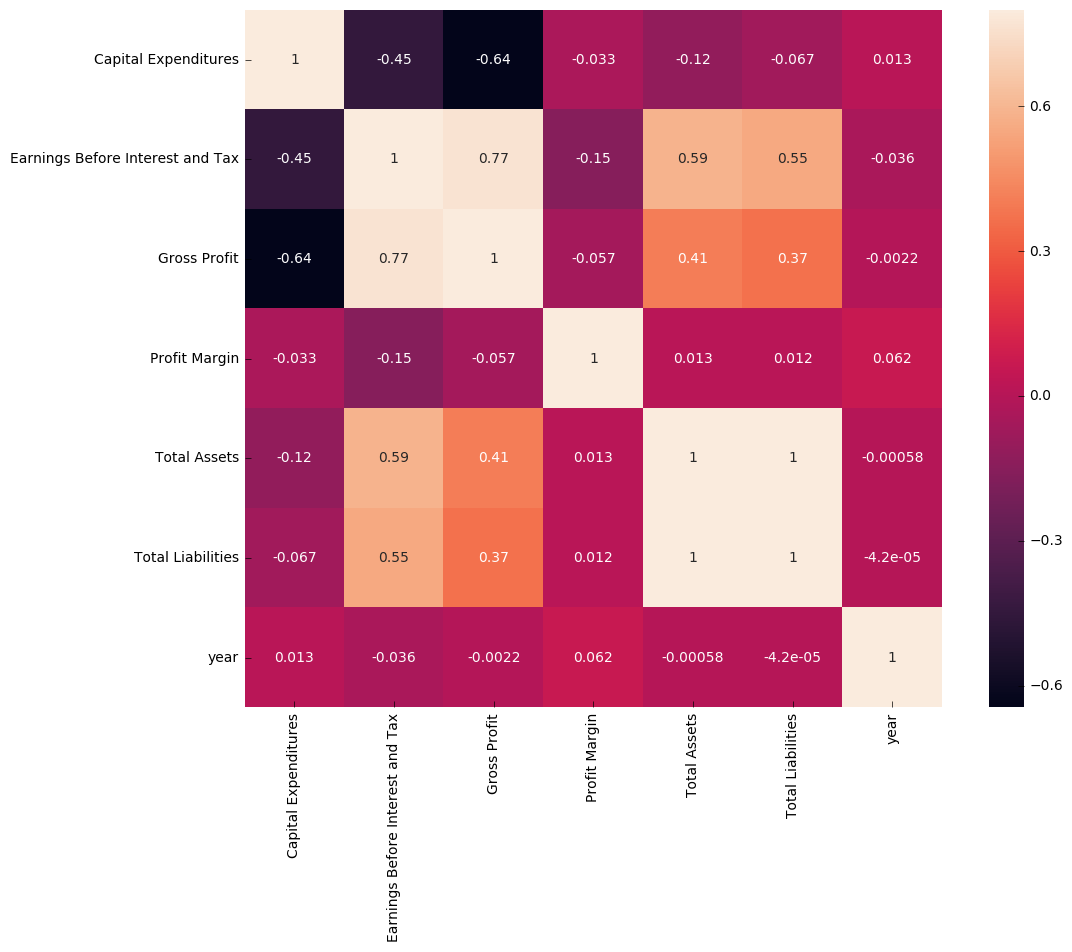

In [6]:
# Create correlation matrix.
corrmat = df_sub.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True)
plt.show()

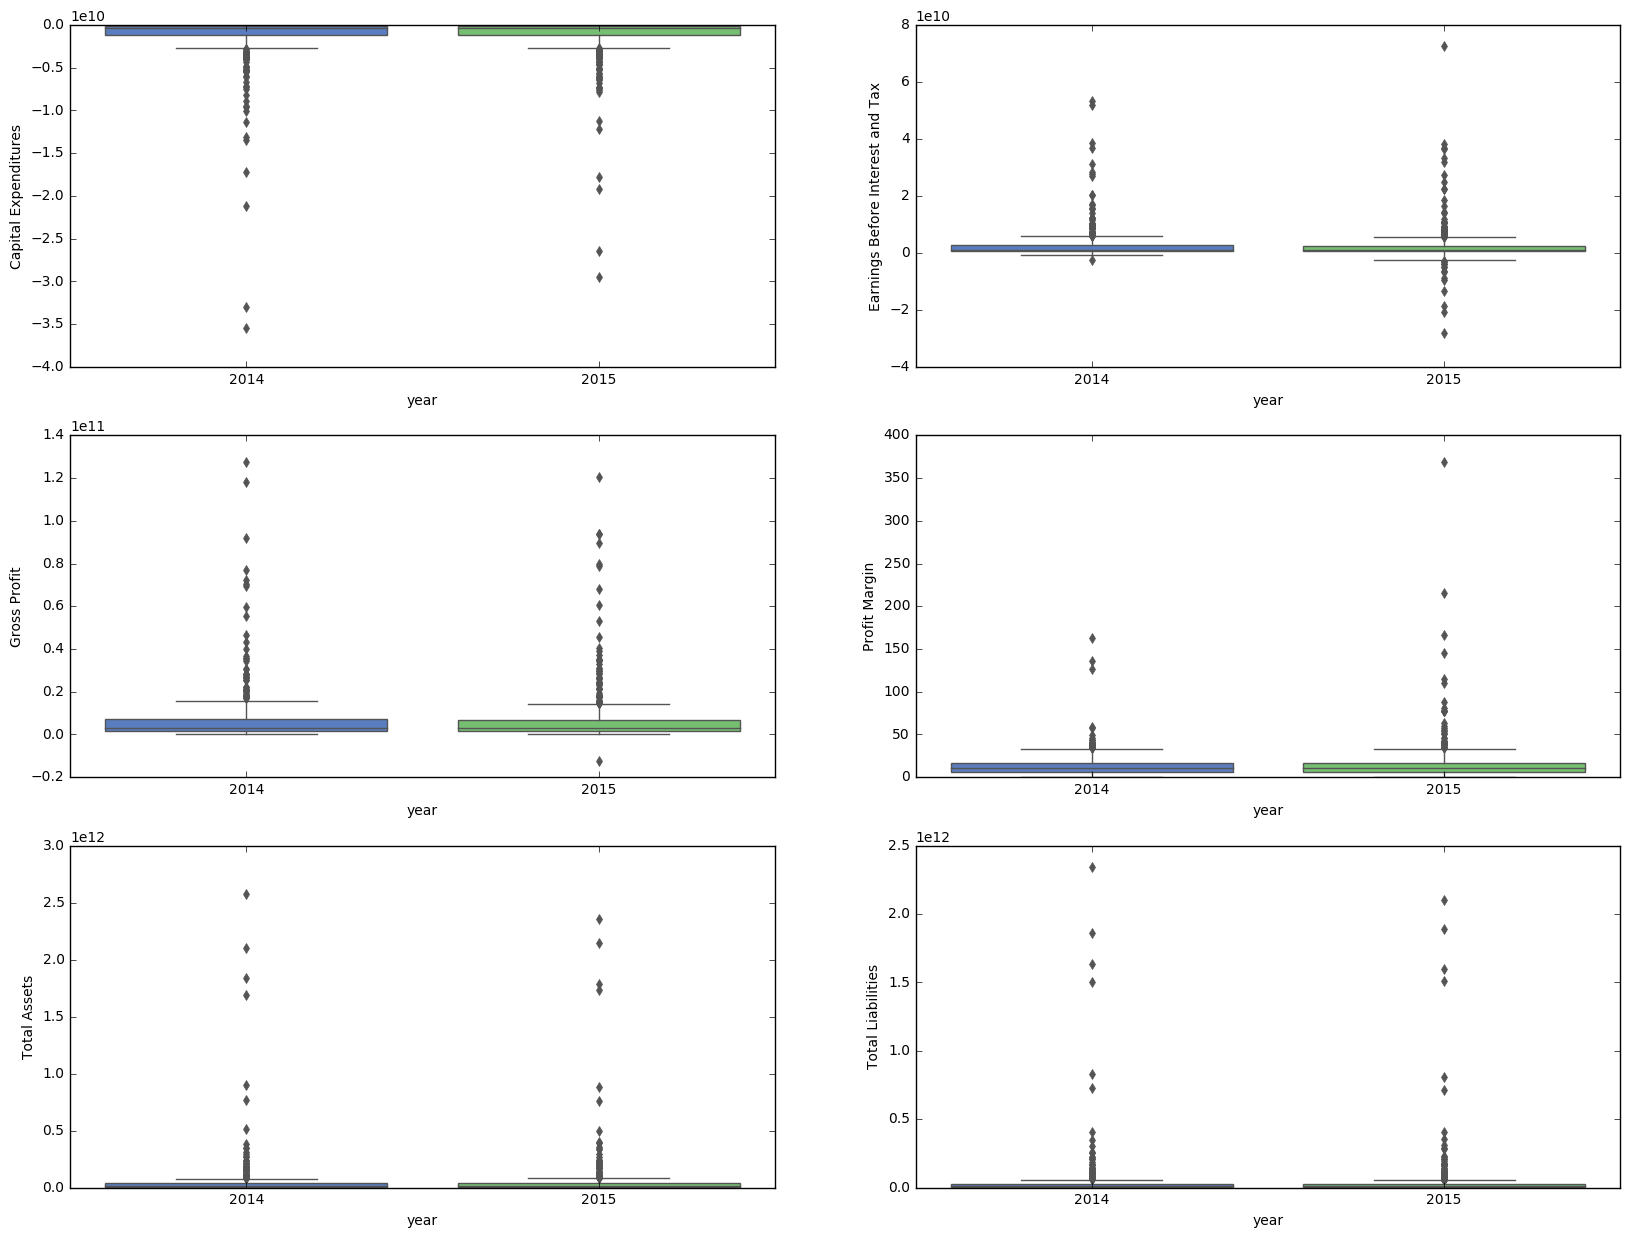

In [7]:
# Craete boxplots to compare the six variables.
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)

cap = sns.boxplot(x='year', y='Capital Expenditures', palette='muted', data=df_sub, ax=ax1)
ebit = sns.boxplot(x='year', y='Earnings Before Interest and Tax', palette='muted', data=df_sub, ax=ax2)
gp = sns.boxplot(x='year', y='Gross Profit', palette='muted', data=df_sub, ax=ax3)
pm = sns.boxplot(x='year', y='Profit Margin', palette='muted', data=df_sub, ax=ax4)
ta = sns.boxplot(x='year', y='Total Assets', palette='muted', data=df_sub, ax=ax5)
tl = sns.boxplot(x='year', y='Total Liabilities', palette='muted', data=df_sub, ax=ax6)
plt.show()

In [8]:
for col in df_sub.loc[:,'Capital Expenditures':'Total Liabilities'].columns:
    print(col)
    print(stats.ttest_ind(
        df_sub[df_sub['year'] == 2014][col].dropna(),
        df_sub[df_sub['year'] == 2015][col].dropna()
    ))

# No significance between the two years.

Capital Expenditures
Ttest_indResult(statistic=-0.38551449681274358, pvalue=0.69994954326524628)
Earnings Before Interest and Tax
Ttest_indResult(statistic=1.0652328204279902, pvalue=0.28706309908892941)
Gross Profit
Ttest_indResult(statistic=0.065629108959937621, pvalue=0.94768803649559397)
Profit Margin
Ttest_indResult(statistic=-1.8329795698615532, pvalue=0.067143683970031481)
Total Assets
Ttest_indResult(statistic=0.017330225568227078, pvalue=0.98617710547643866)
Total Liabilities
Ttest_indResult(statistic=0.0012308591744690704, pvalue=0.99901819599499164)


In [9]:
# Create dataframe to hold features.
features = pd.get_dummies(df['year'])
features['Recent'] = np.where((df['year'].isin([2014, 2015, 2016])), 1, 0)
print(pd.crosstab(features['Recent'], df['year']))

year    2003  2004  2006  2007  2012  2013  2014  2015  2016  2017
Recent                                                            
0          1     1     1     1   236   439     0     0     0     1
1          0     0     0     0     0     0   436   445   220     0


In [10]:
# Create a categorical variable based om profit margin.
features['high_margin'] = np.where(df['Profit Margin']>=10, 1, 0)
print(df['Profit Margin'].groupby(features['high_margin']).describe())

high_margin       
0            count    799.000000
             mean       5.392991
             std        2.516263
             min        0.000000
             25%        3.000000
             50%        6.000000
             75%        8.000000
             max        9.000000
1            count    982.000000
             mean      20.926680
             std       21.117909
             min       10.000000
             25%       12.000000
             50%       16.000000
             75%       22.000000
             max      369.000000
Name: Profit Margin, dtype: float64


In [11]:
# Find the highest correlated variables to gross profit.
corrmat2 = df.corr()
print(corrmat2['Gross Profit'][(corrmat2['Gross Profit']>.8) & (corrmat2['Gross Profit']!=1)])

Earnings Before Interest and Tax    0.805251
Operating Income                    0.842656
Total Revenue                       0.817326
Name: Gross Profit, dtype: float64


In [12]:
# Combine highly correlated variables.
means = df[['Gross Profit','Earnings Before Interest and Tax','Operating Income', 'Total Revenue']].mean(axis=0)
stds = df[['Gross Profit','Earnings Before Interest and Tax','Operating Income', 'Total Revenue']].std(axis=0)
features['earnings'] = ((df[['Gross Profit','Earnings Before Interest and Tax','Operating Income', 'Total Revenue']] - means) / stds).mean(axis=1)
plotdf = df.loc[:, ['Gross Profit','Earnings Before Interest and Tax','Operating Income', 'Total Revenue']]
plotdf['earnings'] = features['earnings'] 
corrmat3 = plotdf.corr()
print(corrmat3)

                                  Gross Profit  \
Gross Profit                          1.000000   
Earnings Before Interest and Tax      0.805251   
Operating Income                      0.842656   
Total Revenue                         0.817326   
earnings                              0.942889   

                                  Earnings Before Interest and Tax  \
Gross Profit                                              0.805251   
Earnings Before Interest and Tax                          1.000000   
Operating Income                                          0.909479   
Total Revenue                                             0.700922   
earnings                                                  0.929398   

                                  Operating Income  Total Revenue  earnings  
Gross Profit                              0.842656       0.817326  0.942889  
Earnings Before Interest and Tax          0.909479       0.700922  0.929398  
Operating Income                          1.

C:\Users\James\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


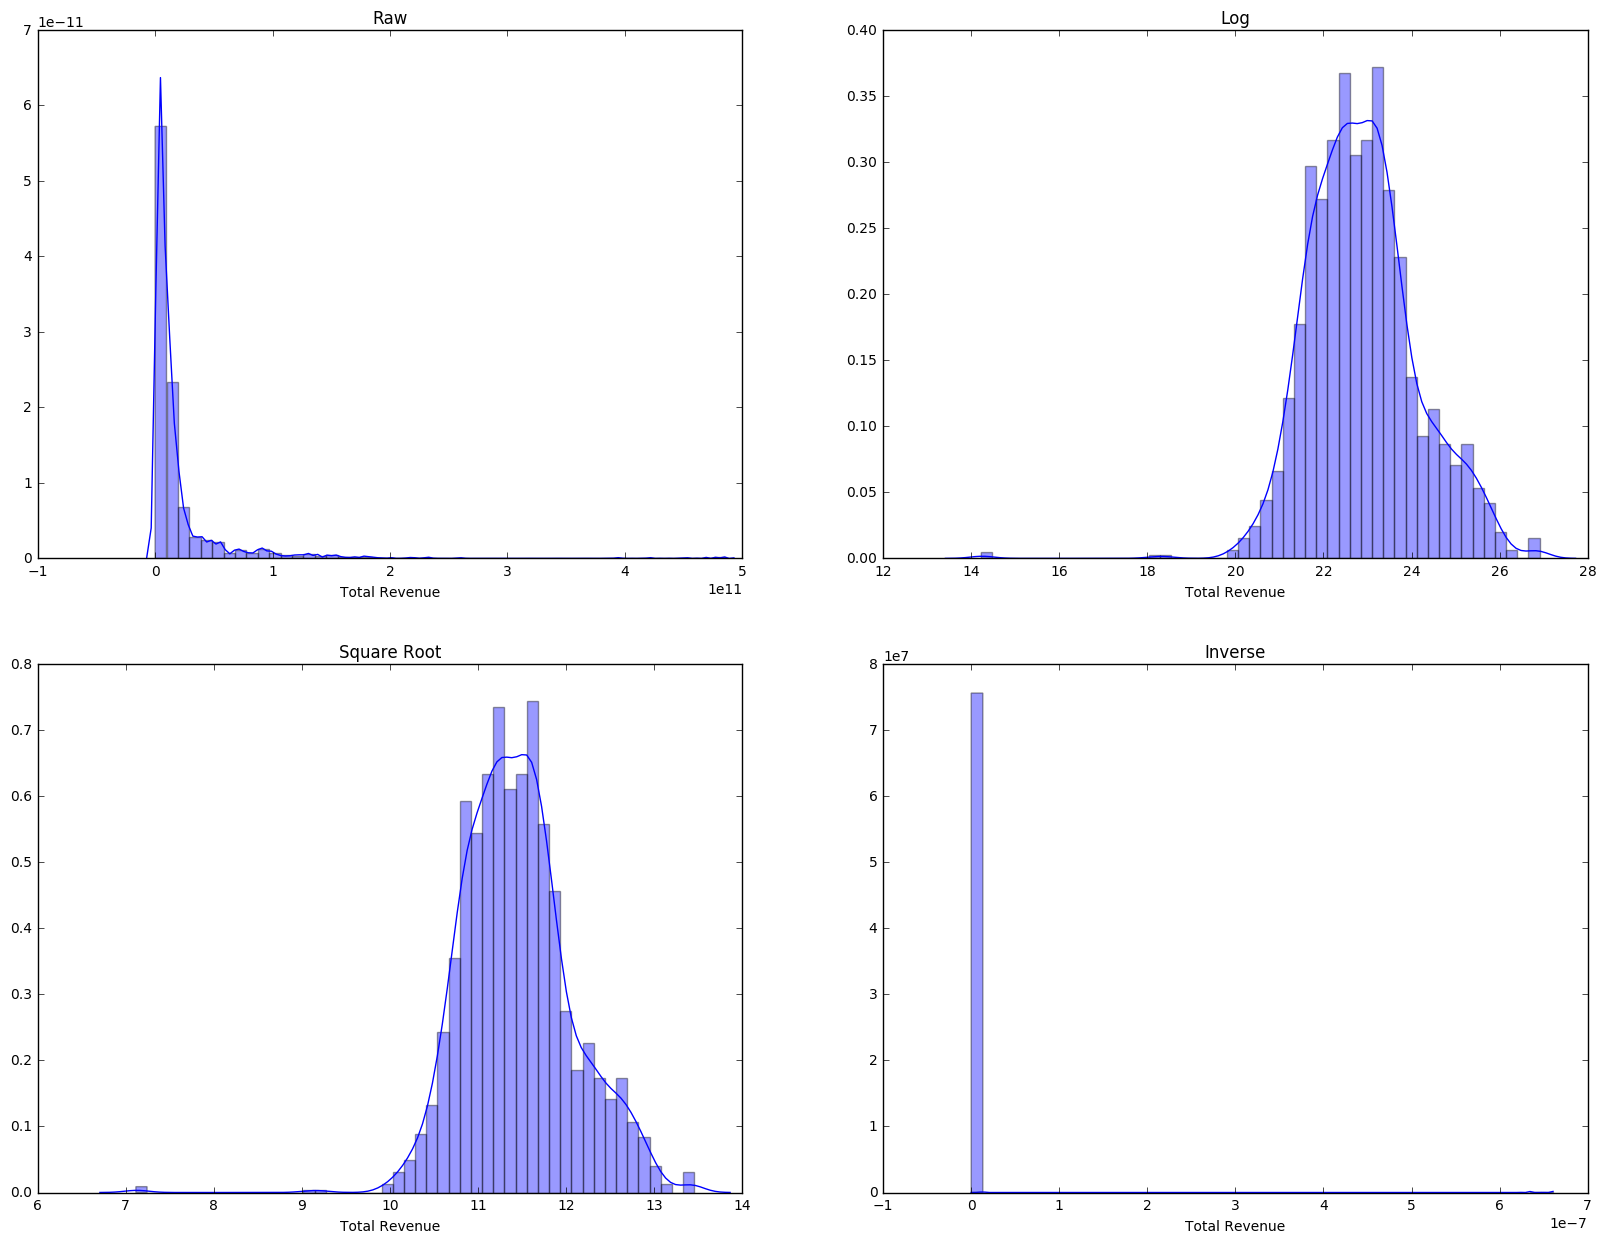

In [13]:
# Show variable transformation.
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

tr1=sns.distplot(df['Total Revenue'].dropna(), hist=True, ax=ax1)
ax1.set_title('Raw')
tr2=sns.distplot(np.log(df['Total Revenue'].dropna()), hist=True, ax=ax2)
ax2.set_title('Log')
tr3=sns.distplot(np.log(np.sqrt(df['Total Revenue'].dropna())), hist=True, ax=ax3)
ax3.set_title('Square Root')
tr4=sns.distplot(1/df['Total Revenue'].dropna(), hist=True, ax=ax4)
ax4.set_title('Inverse')
plt.show()

# Create features from some of the transformation.
features['log_total_revenue'] = np.log(df['Total Revenue'])
features['square_root_total_revenue'] = np.log(np.sqrt(df['Total Revenue'].dropna()))

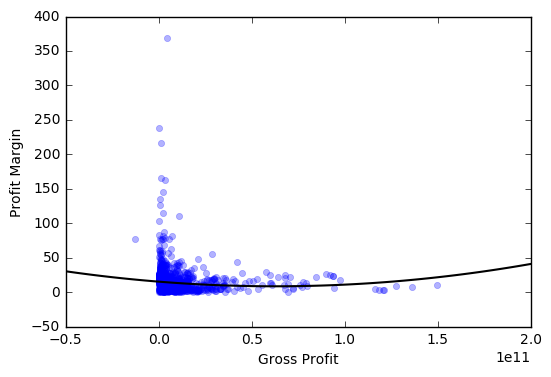

In [14]:
# Show non-linearity between variables.
sns.regplot(
    df['Gross Profit'],
    y=df['Profit Margin'],
    y_jitter=.49,
    order=2,
    scatter_kws={'alpha':0.3},
    line_kws={'color':'black'},
    ci=None
)
plt.show()

features['profit_margin_squared'] = df['Profit Margin'] * df['Profit Margin']
features['cash_ratio_squared'] = df['Cash Ratio'] * df['Cash Ratio']

C:\Users\James\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:167: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


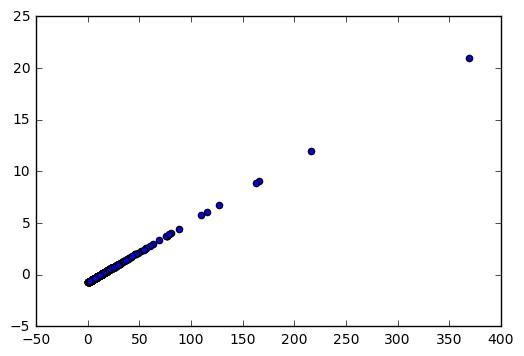

         Unnamed: 0  Accounts Payable  Accounts Receivable  \
count  1.299000e+03      1.299000e+03         1.299000e+03   
mean   1.779964e-14     -8.248470e-16         7.303813e-16   
std    1.000385e+00      1.000385e+00         1.000385e+00   
min   -1.774262e+00     -4.876323e-01        -1.202930e+01   
25%   -8.269412e-01     -4.122634e-01        -5.158417e-02   
50%    6.149513e-03     -3.111351e-01         9.925660e-02   
75%    8.638588e-01     -6.013303e-02         1.711474e-01   
max    1.729446e+00      7.635306e+00         8.987810e+00   

       Add'l income/expense items  After Tax ROE  Capital Expenditures  \
count                1.299000e+03   1.299000e+03          1.299000e+03   
mean                -4.196241e-16   1.473407e-16          6.310921e-16   
std                  1.000385e+00   1.000385e+00          1.000385e+00   
min                 -6.154415e+00  -1.890961e-01         -1.080434e+01   
25%                 -1.212111e-01  -1.450595e-01          2.145121e-02 

In [15]:
# Normalize variables to same scale.
df_num = df.select_dtypes(include=[np.number]).dropna()
names=df_num.columns
df_scaled = pd.DataFrame(preprocessing.scale(df_num), columns=names)
plt.scatter(df_num['Profit Margin'], df_scaled['Profit Margin'])
plt.show()

print(df_scaled.describe())

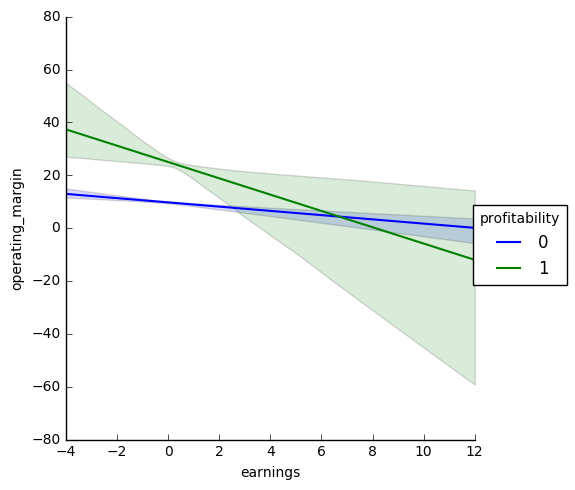

In [16]:
# Show interaction between some variables.
features['profitability'] = np.where(df['Profit Margin'] >= 10, 1, 0)
features['earnings_profitability'] = features['earnings'] * features['profitability']

features['operating_margin'] = df['Operating Margin']
sns.lmplot(
    x='earnings',
    y='operating_margin',
    hue='profitability',
    data=features,
    scatter=False
)
plt.show()

In [17]:
# Show variables weakly correlated to Gross Profit.
print(corrmat2['Gross Profit'][(corrmat2['Gross Profit']<.7) & (corrmat2['Gross Profit']>.2) & (corrmat2['Gross Profit']!=1)])

# Create a PCA subset
df_pca = df.loc[(df['year']==2015)|(df['year']==2014), ['Gross Profit', 'Accounts Payable', 'Fixed Assets', 'Long-Term Debt', 'Total Assets', 'Total Liabilities']].dropna()

Accounts Payable                                       0.556735
Add'l income/expense items                             0.264486
Capital Surplus                                        0.427153
Cash and Cash Equivalents                              0.219473
Cost of Revenue                                        0.666179
Deferred Liability Charges                             0.559337
Equity Earnings/Loss Unconsolidated Subsidiary         0.459577
Fixed Assets                                           0.634646
Goodwill                                               0.484648
Intangible Assets                                      0.407243
Interest Expense                                       0.405422
Inventory                                              0.436967
Long-Term Debt                                         0.543002
Long-Term Investments                                  0.267307
Minority Interest                                      0.404273
Net Income Adjustments                  

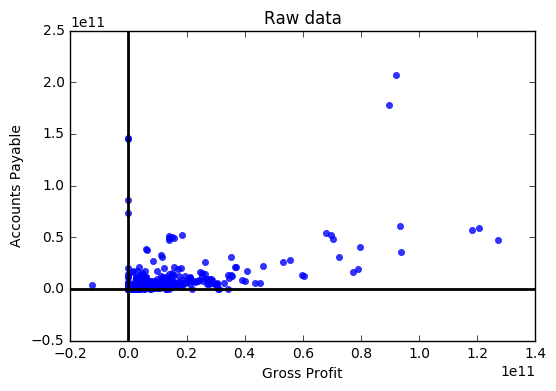

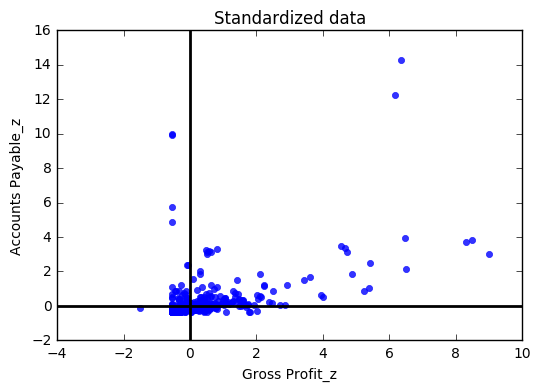

In [18]:
# Compare Gross Profit and Accounts Payable. 
t1 = sns.regplot('Gross Profit','Accounts Payable',df_pca,fit_reg=False)
t1.axhline(0, color='k', linestyle='-', linewidth=2)
t1.axvline(0, color='k', linestyle='-', linewidth=2)
t1.axes.set_title('Raw data')
plt.show()

# Standardize variables.
df_pca['Gross Profit_z'] = (df_pca['Gross Profit'] - df_pca['Gross Profit'].mean()) / df_pca['Gross Profit'].std()
df_pca['Accounts Payable_z'] = (df_pca['Accounts Payable'] - df_pca['Accounts Payable'].mean()) / df_pca['Accounts Payable'].std()

t2 = sns.regplot('Gross Profit_z','Accounts Payable_z',df_pca,fit_reg=False)
t2.axhline(0, color='k', linestyle='-', linewidth=2)
t2.axvline(0, color='k', linestyle='-', linewidth=2)
t2.axes.set_title('Standardized data')
plt.show()

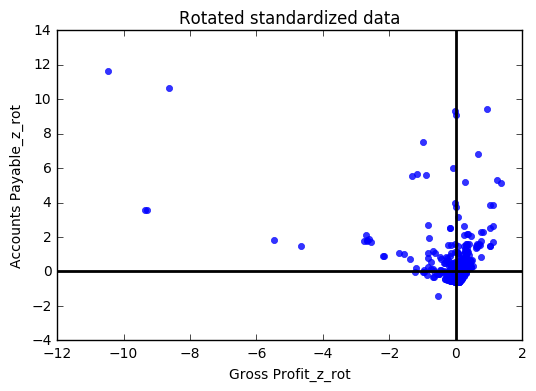

In [19]:
df_pca['Gross Profit_z_rot'] = math.cos(20) * df_pca['Gross Profit_z'] - math.sin(20) * df_pca['Accounts Payable_z']
df_pca['Accounts Payable_z_rot'] = math.sin(20) * df_pca['Gross Profit_z'] + math.cos(20) * df_pca['Accounts Payable_z']

t3 = sns.regplot('Gross Profit_z_rot','Accounts Payable_z_rot',df_pca,fit_reg=False)
t3.axhline(0, color='k', linestyle='-', linewidth=2)
t3.axvline(0, color='k', linestyle='-', linewidth=2)
t3.axes.set_title('Rotated standardized data')
plt.show()

In [44]:
# Conduct PCA on entire dataset.
# Drop non-numeric variables and rows with missing values.
df1 = df.drop(['Unnamed: 0', 'Period Ending'], axis=1).dropna()

# Extract Ticker Symbol column.
cols = df1.columns.tolist()
cols.insert(0, cols.pop(cols.index('Ticker Symbol')))
df1 = df1.reindex(columns= cols)
df2 = df1.iloc[:,1:].values
df3 = pd.DataFrame(data=df1.iloc[:,0].values)

# Standardize data and create covariance matrix.
X_std = StandardScaler().fit_transform(df2)
print(np.cov(X_std.T))

[[ 1.00077042 -0.20397547  0.31055163 ...,  0.14181629  0.5193928
   0.03284907]
 [-0.20397547  1.00077042 -0.0165555  ..., -0.09307728 -0.17485857
   0.02911951]
 [ 0.31055163 -0.0165555   1.00077042 ...,  0.09748752  0.18287878
  -0.01687119]
 ..., 
 [ 0.14181629 -0.09307728  0.09748752 ...,  1.00077042 -0.05189025
  -0.01358919]
 [ 0.5193928  -0.17485857  0.18287878 ..., -0.05189025  1.00077042
   0.00667264]
 [ 0.03284907  0.02911951 -0.01687119 ..., -0.01358919  0.00667264
   1.00077042]]


In [26]:
# Perform eigendecomposition: derive eigenvectors and eigenvalues.
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ -1.61291489e-01  -1.44423261e-02   9.79138686e-02 ...,  -1.47725463e-04
   -1.07857591e-04  -2.74363098e-04]
 [  4.21710820e-02   8.63840633e-02   6.98069890e-02 ...,   5.24383003e-07
    2.71867356e-05   2.12923486e-06]
 [ -7.24697828e-02  -2.40430521e-02   1.02080542e-01 ...,  -1.01443996e-06
   -4.98615736e-05   1.55363423e-06]
 ..., 
 [ -2.86411607e-02  -1.65858822e-01   1.53013315e-01 ...,   3.50102666e-08
    2.50358551e-05  -5.90544150e-06]
 [ -1.45018622e-01  -4.37046427e-02  -1.58876617e-01 ...,  -1.31296514e-06
    1.91744096e-05   7.92094587e-07]
 [ -1.23773234e-03  -2.64549972e-02  -2.16383843e-02 ...,   9.81273701e-07
    1.09188308e-05  -2.77101062e-06]]

Eigenvalues 
[  2.74136357e+01   5.03341684e+00   4.80450517e+00   4.09169854e+00
   3.10137419e+00   2.69605876e+00   2.42872675e+00   2.11728637e+00
   1.97649583e+00   1.79859788e+00   1.64080749e+00   1.38818544e+00
   1.35220452e+00   1.21547435e+00   1.06508557e+00   1.00801180e+00
   9.81745409e-0

In [27]:
# List eigenvalues in descending order.
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
27.413635688
5.03341683895
4.80450517245
4.09169854216
3.10137418793
2.69605876125
2.42872674852
2.11728636672
1.9764958282
1.79859788049
1.64080748828
1.38818543573
1.35220452291
1.215474355
1.06508556665
1.0080117974
0.981745408885
0.951303766886
0.889018040268
0.854445693075
0.825948913381
0.766491872328
0.680011148239
0.661455767522
0.619072464743
0.570228805709
0.551397382581
0.499086200357
0.46058714569
0.438777357422
0.415489412832
0.358951715087
0.332454423637
0.311422434717
0.283381842253
0.252482106952
0.221188362473
0.209814028078
0.192149620745
0.189670449758
0.153850952677
0.149216707001
0.123480771541
0.119909090781
0.116748292265
0.103778431842
0.0914309057067
0.0824371334612
0.0758749115773
0.060683672024
0.0576430701475
0.04892923821
0.0477278543108
0.0384665003785
0.0317807368179
0.028194439794
0.0221804935742
0.0254079728778
0.0115011455338
0.00970321393391
0.00374774743301
0.00304426012059
0.00207772529357
0.00122506023075
0.00114259

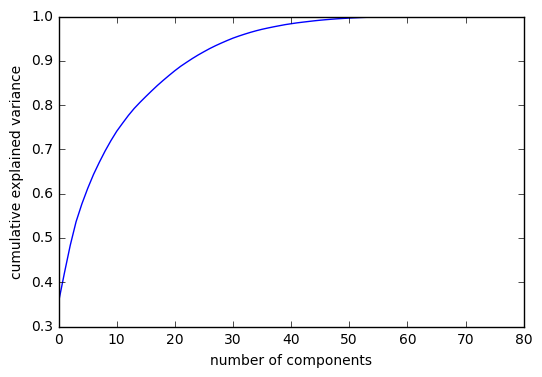

In [28]:
# Plot cumulative explained variance to determine how many principal components to choose for the new feature subspace.
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

# 90% of the variance comes from 22 principal components; therefore, pick the top 22 eigenvalues from above.

In [29]:
# Construct the new feature subspace.
sklearn_pca = PCA(n_components=22)
Y_sklearn = sklearn_pca.fit_transform(X_std)
print(Y_sklearn)

[[-1.07329807  1.76886872 -0.42731695 ...,  0.86107116  0.50246662
  -1.21944048]
 [ 0.10395134  2.21969814 -1.85638796 ...,  1.06877013  0.42236738
  -1.20611134]
 [ 2.19594807  1.36524116 -0.13720712 ...,  0.23393182 -0.0936329
  -1.55234419]
 ..., 
 [-1.85153116 -0.16569166 -0.51938793 ..., -0.63923299 -0.7001035
   2.60810993]
 [-2.26082779 -0.43851507 -0.24343284 ..., -0.11082275 -0.11391443
   0.14165568]
 [-2.04506005 -0.20782774 -0.03633732 ..., -0.13137409 -0.44583037
   0.12243184]]


In [30]:
Y_sklearn.shape
# The 77 variables were reduced to 22 principal components at 90% variance.

(1299, 22)

In [48]:
# Construct the new dataframe with the principal components.
df4 = pd.DataFrame(data = Y_sklearn, columns = ['pc1','pc2','pc3','pc4','pc5','pc6','pc7','pc8','pc9','pc10','pc11','pc12','pc13','pc14','pc15','pc16','pc17','pc18','pc19','pc20','pc21','pc22'])
df5 = pd.concat([df3, df4], axis = 1)
df5.head()

,0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22
0,AAL,-1.073298,1.768869,-0.427317,-1.817086,0.022531,-1.781913,-0.749164,-0.663926,-0.505392,...,0.125092,0.102156,-0.981891,2.153613,-1.169340,-2.681808,0.330797,0.861071,0.502467,-1.219440
1,AAL,0.103951,2.219698,-1.856388,-2.464083,0.143052,-1.922282,-1.261699,-0.154903,-0.658102,...,-0.681980,-0.163373,-0.952659,1.586087,-1.633796,-2.734779,0.048637,1.068770,0.422367,-1.206111
2,AAL,2.195948,1.365241,-0.137207,-1.042759,-0.260225,-1.023279,-1.147517,-1.021067,0.569860,...,-0.155146,0.069450,-0.599843,-0.244256,-0.644702,-2.253797,-0.098953,0.233932,-0.093633,-1.552344
3,AAL,3.165962,0.518333,-0.084221,-0.940497,-0.384735,-0.724116,-1.171208,-0.217967,1.034945,...,-0.646466,-1.330708,-0.365976,-1.143388,0.608193,-2.201268,-0.283713,0.190858,-1.873869,-1.155798
4,AAP,-2.302505,-0.255089,1.204766,-0.328933,-0.664719,-0.342134,0.310740,0.436820,-0.197199,...,0.184175,0.496293,-0.199368,1.026321,0.175893,-0.480880,0.265265,-0.245796,-0.636032,0.594241
